In [1]:
%run ./function.ipynb

In [2]:
PATH = 'D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/'
FILE = 'TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv'
df = pd.read_csv(PATH + FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [3]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [4]:
df['TO_SAR'].value_counts()

0    86324
1      446
Name: TO_SAR, dtype: int64

In [5]:
df.shape

(86770, 45)

In [6]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


In [7]:
SAR = train_set[train_set.TO_SAR!= 0]
Non_SAR = train_set[train_set.TO_SAR== 0]

## 分析 information gain 和 recall and filter rate 的關係

### hreshold: 現金存款累積>=&1101_amount元

In [8]:
import seaborn as sns

In [9]:
median = SplitMedian(train_set, 'Credit_Amt')

len of median: 17787


<AxesSubplot:xlabel='Credit_Amt'>

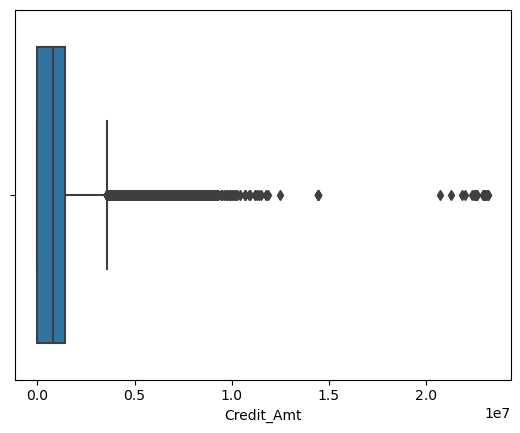

In [10]:
sns.boxplot(x= train_set['Credit_Amt'])

In [11]:
# credit 存款, 小於等於{金額}留下, SAR=0 Credit_Amt值較大, upper bound
# train set
results = pd.DataFrame(columns = ['Credit_Amt', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

father_entropy = Entropy(train_set, 'TO_SAR')
for thre in median:
#     new_SAM_1 = train_set[train_set['Credit_Amt']<= thre]
#     new_SAM_0 = train_set[train_set['Credit_Amt']> thre]
    
    new_SAM_1 = train_set[train_set['Credit_Amt'] > thre]
    new_SAM_0 = train_set[train_set['Credit_Amt']<= thre]
    
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    
    results = results.append({'Credit_Amt':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [13]:
results['recall'] = results['recall'].astype('float')
results['filter rate'] = results['filter rate'].astype('float')

In [14]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)

,Credit_Amt,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate


In [15]:
results['filter rate'] = results['filter rate'].astype('float')
results.loc[:, ['Credit_Amt' ,'information gain', 'recall', 'filter rate']].corr()

,Credit_Amt,information gain,recall,filter rate
Credit_Amt,1.000000,-0.684741,-0.676717,0.714078
information gain,-0.684741,1.000000,0.906222,-0.964898
recall,-0.676717,0.906222,1.000000,-0.983944
filter rate,0.714078,-0.964898,-0.983944,1.000000


<AxesSubplot:xlabel='TO_SAR', ylabel='Credit_Amt'>

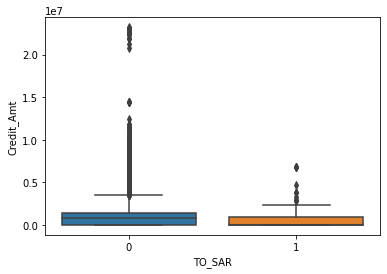

In [110]:
sns.boxplot(x= train_set['TO_SAR'], y= train_set['Credit_Amt'])

In [26]:
results.sort_values(by= 'information gain')

,Credit_Amt,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
17126,5461310.00,1.424894e-07,267,51794,4,776,263,51017,0.0150,0.9850
17127,5463102.50,1.425685e-07,267,51794,4,775,263,51018,0.0150,0.9850
17125,5460457.50,1.425962e-07,267,51794,4,777,263,51016,0.0150,0.9850
17128,5464750.00,1.428340e-07,267,51794,4,774,263,51019,0.0150,0.9850
17124,5455000.00,1.428885e-07,267,51794,4,778,263,51015,0.0150,0.9850
...,...,...,...,...,...,...,...,...,...,...
3617,994174.00,8.848869e-04,267,51794,61,24086,206,27707,0.2285,0.5362
3616,994100.00,8.850221e-04,267,51794,61,24087,206,27706,0.2285,0.5361
3615,994050.26,8.851573e-04,267,51794,61,24088,206,27705,0.2285,0.5361
3614,994035.76,8.852925e-04,267,51794,61,24089,206,27704,0.2285,0.5361


<AxesSubplot:xlabel='Credit_Amt', ylabel='information gain'>

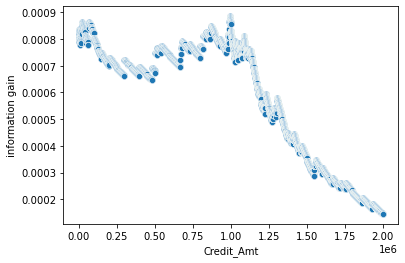

In [25]:
sns.scatterplot(x= results.loc[results['Credit_Amt']<2e6, 'Credit_Amt'], y= results['information gain'])

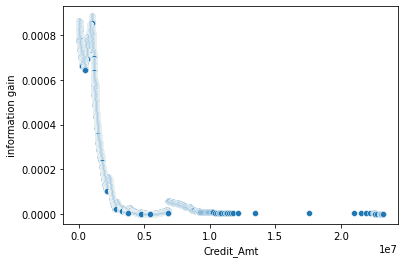

In [17]:
sns.scatterplot(x= results['Credit_Amt'], y= results['information gain'])
#plt.savefig('C:/Users/NCTUUser2/Desktop/threshold_information_gain.png')
plt.show()

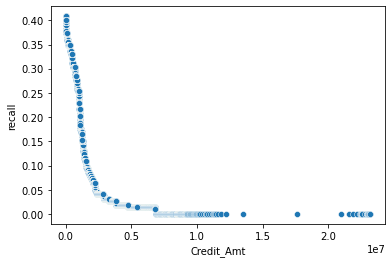

In [18]:
sns.scatterplot(x= results['Credit_Amt'], y= results['recall'])
plt.savefig('C:/Users/NCTUUser2/Desktop/threshold_recall.png')
plt.show()

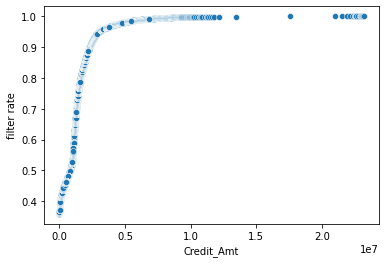

In [81]:
sns.scatterplot(x= results['Credit_Amt'], y= results['filter rate'])
plt.savefig('C:/Users/NCTUUser2/Desktop/threshold_filter_rate.png')
plt.show()

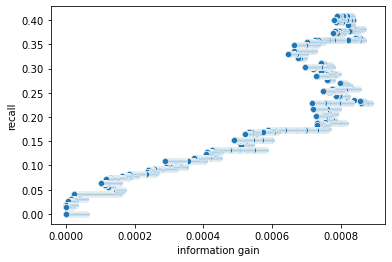

In [82]:
sns.scatterplot(x= results['information gain'], y= results['recall'])
plt.savefig('C:/Users/NCTUUser2/Desktop/information_gain_recall.png')
plt.show()

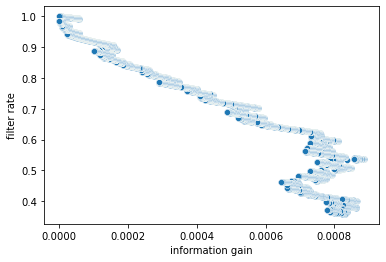

In [83]:
sns.scatterplot(x= results['information gain'], y= results['filter rate'])
plt.savefig('C:/Users/NCTUUser2/Desktop/information_gain_filter_rate.png')
plt.show()

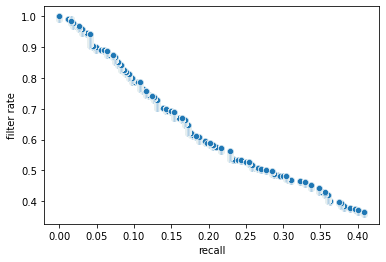

In [84]:
sns.scatterplot(x= results['recall'], y= results['filter rate'])
plt.savefig('C:/Users/NCTUUser2/Desktop/recall_filter_rate.png')
plt.show()

<AxesSubplot:xlabel='information gain'>

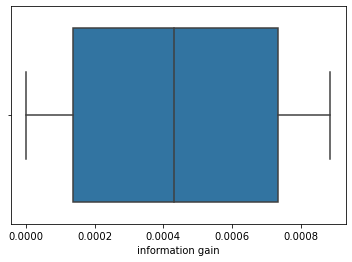

In [16]:
sns.boxplot(x = results['information gain'])

<AxesSubplot:xlabel='information gain', ylabel='Count'>

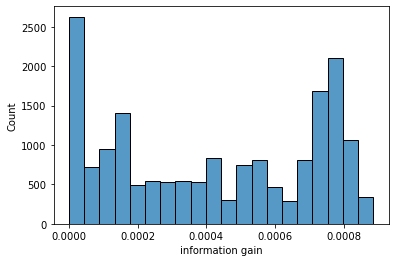

In [17]:
sns.histplot(x= results['information gain'])

<AxesSubplot:xlabel='recall', ylabel='information gain'>

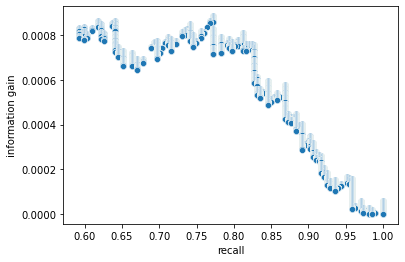

In [21]:
sns.scatterplot(x= 'recall', y= 'information gain', data= results)

<AxesSubplot:xlabel='recall', ylabel='information gain'>

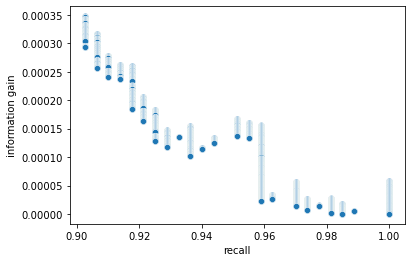

In [22]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'information gain', data = data)

<AxesSubplot:xlabel='filter rate', ylabel='information gain'>

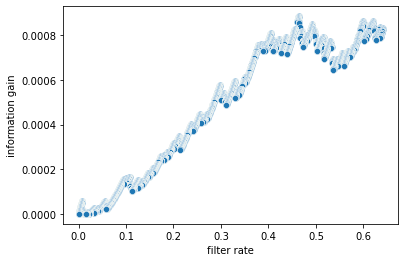

In [19]:
sns.scatterplot(x = 'filter rate', y= 'information gain', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

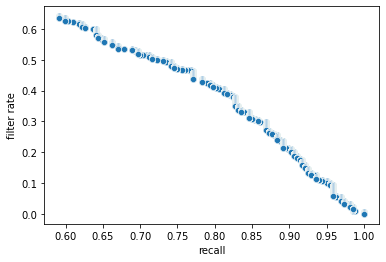

In [20]:
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

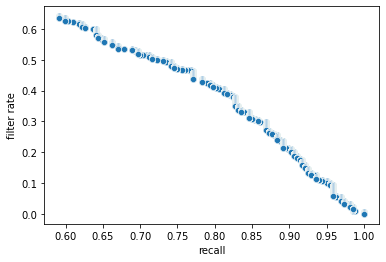

In [21]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

<AxesSubplot:xlabel='threshold', ylabel='recall'>

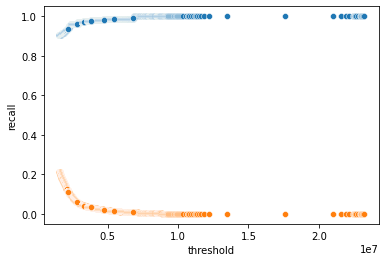

In [61]:
#sns.scatterplot(x= 'threshold', y= 'information gain', data= data)
sns.scatterplot(x= 'threshold', y= 'recall', data= data)
sns.scatterplot(x= 'threshold', y= 'filter rate', data= data)

In [53]:
feature = 'Credit_Amt'
label = 1
day = 15

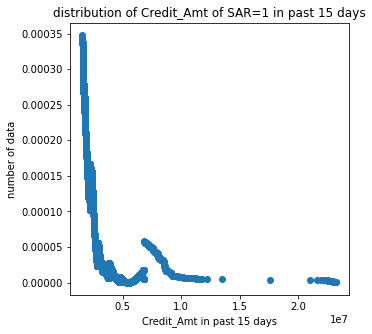

In [58]:
plt.figure(figsize= (5, 5))
plt.scatter(data['threshold'], data['information gain'])
#plt.scatter(data['threshold'], data['filter rate'], c= 'g')
plt.title('distribution of {} of SAR={} in past {} days'.format(feature, label, day))
plt.xlabel("{} in past {} days".format(feature, day))
plt.ylabel('number of data')
plt.show()

### threshold: 現金存款累計次數>=&1101_trans_num次

In [18]:
median = SplitMedian(train_set, 'number_of_Credit')

len of median: 218


In [19]:
# Credit 提款金額 小於等於{金額}留下, SAR=0 number_of_Cebit值較大, upper bound
# train set

results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

father_entropy = Entropy(train_set, 'TO_SAR')
for thre in median:
    new_SAM_1 = train_set[train_set['number_of_Credit']> thre]
    new_SAM_0 = train_set[train_set['number_of_Credit']<= thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

display(results)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,0.5,8.311732e-04,267,51794,109,33269,158,18524,0.4082,0.3588
3,3.5,7.456811e-04,267,51794,85,28050,182,23743,0.3184,0.4596
2,2.5,6.961608e-04,267,51794,92,29045,175,22748,0.3446,0.4403
1,1.5,6.601159e-04,267,51794,100,30305,167,21488,0.3745,0.416
4,4.5,6.397640e-04,267,51794,83,26782,184,25011,0.3109,0.484
...,...,...,...,...,...,...,...,...,...,...
213,829.5,9.974799e-07,267,51794,0,6,267,51787,0.0,0.9999
214,835.0,8.549745e-07,267,51794,0,5,267,51788,0.0,0.9999
215,837.0,7.124719e-07,267,51794,0,4,267,51789,0.0,0.9999
216,840.5,4.274749e-07,267,51794,0,2,267,51791,0.0,0.9999


In [20]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate


In [21]:
results['filter rate'] = results['filter rate'].astype('float')
results.loc[:, ['threshold', 'information gain', 'recall', 'filter rate']].corr()

,threshold,information gain,recall,filter rate
threshold,1.000000,-0.277096,-0.303179,0.310735
information gain,-0.277096,1.000000,0.923839,-0.944465
recall,-0.303179,0.923839,1.000000,-0.997617
filter rate,0.310735,-0.944465,-0.997617,1.000000


<AxesSubplot:xlabel='information gain'>

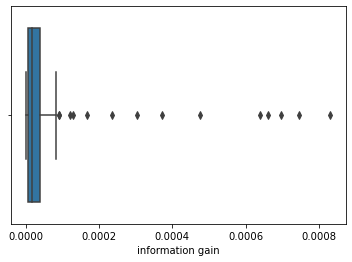

In [26]:
sns.boxplot(x = results['information gain'])

<AxesSubplot:xlabel='information gain', ylabel='Count'>

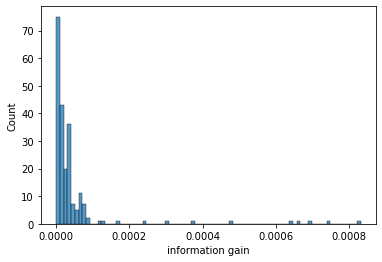

In [27]:
sns.histplot(x= results['information gain'])

<AxesSubplot:xlabel='recall', ylabel='information gain'>

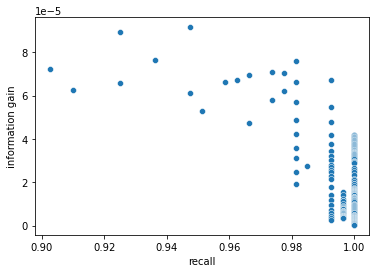

In [28]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'information gain', data = data)

<AxesSubplot:xlabel='filter rate', ylabel='information gain'>

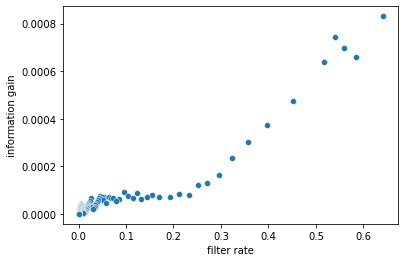

In [29]:
sns.scatterplot(x = 'filter rate', y= 'information gain', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

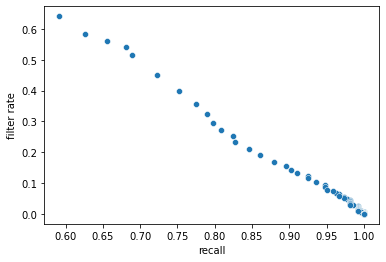

In [30]:
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

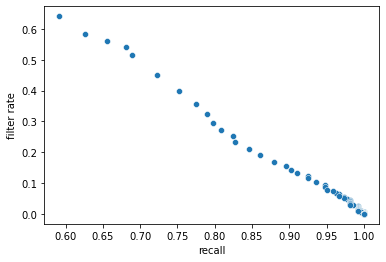

In [31]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

### threshold: 現金提款累積>=&1101_amount元

In [22]:
median = SplitMedian(train_set, 'Debit_Amt')

len of median: 14527


In [23]:
# train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

father_entropy = Entropy(train_set, 'TO_SAR')
for thre in median:
    new_SAM_1 = train_set[train_set['Debit_Amt']> thre]
    new_SAM_0 = train_set[train_set['Debit_Amt']<=thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    if len(new_SAM_0) == 0 or len(new_SAM_1) == 0:
        continue
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

display(results)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
2965,699510.0,1.052532e-03,267,51794,206,26521,61,25272,0.7715,0.4866
2964,698787.5,1.052385e-03,267,51794,206,26522,61,25271,0.7715,0.4866
2963,698411.0,1.052237e-03,267,51794,206,26523,61,25270,0.7715,0.4866
2962,698173.5,1.051942e-03,267,51794,206,26525,61,25268,0.7715,0.4865
2961,697126.0,1.051794e-03,267,51794,206,26526,61,25267,0.7715,0.4865
...,...,...,...,...,...,...,...,...,...,...
13374,3220045.0,1.631904e-07,267,51794,8,1531,259,50262,0.03,0.9704
13373,3220027.5,1.612444e-07,267,51794,8,1532,259,50261,0.03,0.9704
13372,3220012.5,1.593952e-07,267,51794,8,1533,259,50260,0.03,0.9704
13371,3220005.0,1.576427e-07,267,51794,8,1534,259,50259,0.03,0.9704


In [24]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate


In [25]:
results['filter rate'] = results['filter rate'].astype('float')
results.loc[:, ['threshold', 'information gain', 'recall', 'filter rate']].corr()

,threshold,information gain,recall,filter rate
threshold,1.000000,-0.346483,-0.432698,0.429277
information gain,-0.346483,1.000000,0.924085,-0.891039
recall,-0.432698,0.924085,1.000000,-0.995079
filter rate,0.429277,-0.891039,-0.995079,1.000000


<AxesSubplot:xlabel='information gain'>

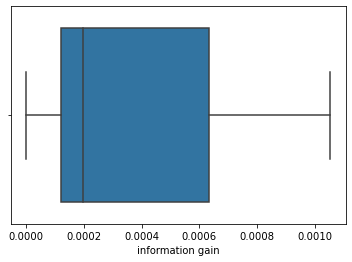

In [43]:
sns.boxplot(x = results['information gain'])

<AxesSubplot:xlabel='information gain', ylabel='Count'>

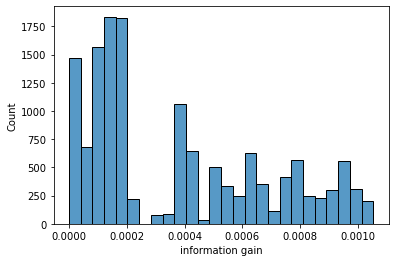

In [44]:
sns.histplot(x= results['information gain'])

<AxesSubplot:xlabel='recall', ylabel='information gain'>

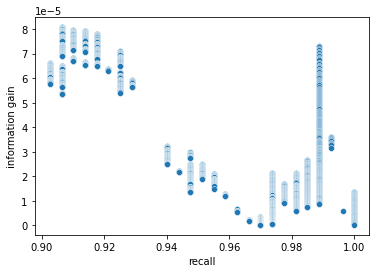

In [45]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'information gain', data = data)

<AxesSubplot:xlabel='filter rate', ylabel='information gain'>

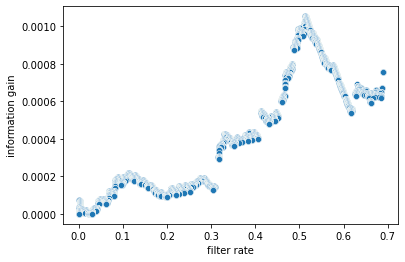

In [46]:
sns.scatterplot(x = 'filter rate', y= 'information gain', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

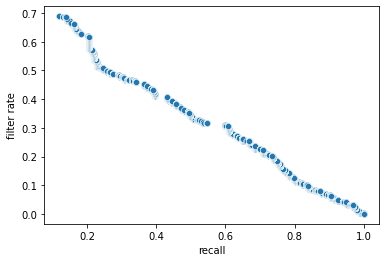

In [47]:
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

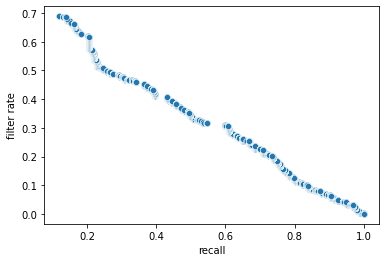

In [48]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

In [ ]:
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

In [ ]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

### threshold: 現金提款累計次數>=&1101_trans_num次

In [26]:
median = SplitMedian(train_set, 'number_of_Debit')

len of median: 154


In [28]:
# train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

father_entropy = Entropy(train_set, 'TO_SAR')
for thre in median:
    new_SAM_1 = train_set[train_set['number_of_Debit']> thre]
    new_SAM_0 = train_set[train_set['number_of_Debit']<= thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    if len(new_SAM_0) == 0 or len(new_SAM_1) == 0:
        continue    
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

display(results)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
14,14.5,1.231346e-03,267,51794,132,11851,135,39942,0.4944,0.7698
13,13.5,1.220228e-03,267,51794,138,12841,129,38952,0.5169,0.7507
8,8.5,1.189441e-03,267,51794,173,19015,94,32778,0.6479,0.6314
9,9.5,1.169935e-03,267,51794,164,17489,103,34304,0.6142,0.6609
12,12.5,1.163119e-03,267,51794,143,13934,124,37859,0.5356,0.7296
...,...,...,...,...,...,...,...,...,...,...
149,166.5,1.567529e-06,267,51794,0,10,267,51783,0.0,0.9998
150,167.5,1.282499e-06,267,51794,0,8,267,51785,0.0,0.9998
151,170.5,5.699720e-07,267,51794,0,3,267,51790,0.0,0.9999
152,174.5,4.274749e-07,267,51794,0,2,267,51791,0.0,0.9999


In [29]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate


In [30]:
results['filter rate'] = results['filter rate'].astype('float')
results.loc[:, ['threshold', 'information gain', 'recall', 'filter rate']].corr()

,threshold,information gain,recall,filter rate
threshold,1.000000,-0.812624,-0.714116,0.606258
information gain,-0.812624,1.000000,0.660930,-0.534469
recall,-0.714116,0.660930,1.000000,-0.978245
filter rate,0.606258,-0.534469,-0.978245,1.000000


<AxesSubplot:xlabel='information gain'>

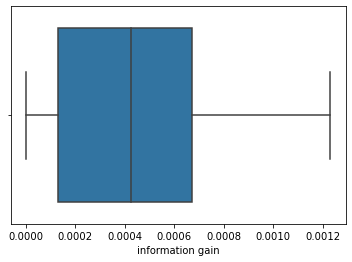

In [53]:
sns.boxplot(x = results['information gain'])

<AxesSubplot:xlabel='information gain', ylabel='Count'>

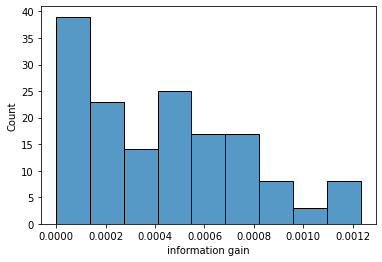

In [54]:
sns.histplot(x= results['information gain'])

<AxesSubplot:xlabel='recall', ylabel='information gain'>

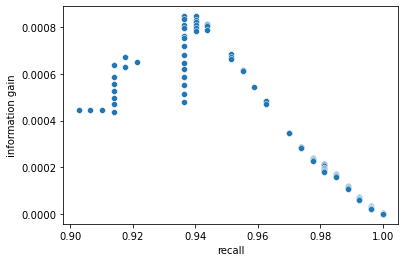

In [55]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'information gain', data = data)

<AxesSubplot:xlabel='filter rate', ylabel='information gain'>

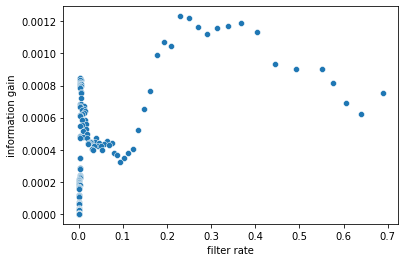

In [56]:
sns.scatterplot(x = 'filter rate', y= 'information gain', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

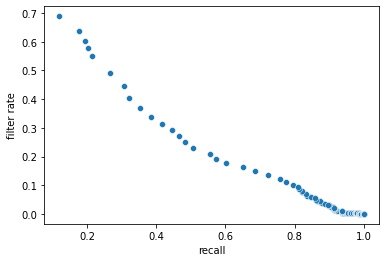

In [57]:
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

<AxesSubplot:xlabel='recall', ylabel='filter rate'>

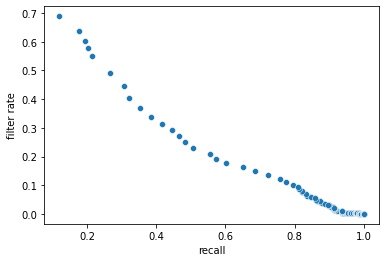

In [58]:
data = results[results['recall']> 0.9]
sns.scatterplot(x= 'recall', y= 'filter rate', data= results)

## Oversampling 

In [8]:
print(f'number of SAR: {len(SAR)}')
print(f'number of Non_SAR: {len(Non_SAR)}')
print(f'Non_SAR / SAR: {len(Non_SAR) / len(SAR)}')

number of SAR: 267
number of Non_SAR: 51794
Non_SAR / SAR: 193.98501872659176


In [9]:
# oversampling 
Res_rate = int(round(len(Non_SAR) / len(SAR)))
temp = train_set[train_set.TO_SAR!= 0]
i=0
while i < Res_rate:
    SAR = SAR.append(temp)
    #print(i, SAR.shape)
    i += 1

In [11]:
print(f'number of SAR: {len(SAR)}')
print(f'number of Non_SAR: {len(Non_SAR)}')
print(f'Non_SAR / SAR: {len(Non_SAR) / len(SAR)}')

number of SAR: 52065
number of Non_SAR: 51794
Non_SAR / SAR: 0.9947949678286757


In [12]:
new_train_set = pd.concat([SAR, Non_SAR])
new_train_set.shape

(103859, 38)

In [13]:
train_set.shape

(52061, 38)

### threshold: 現金存款累積>=&1101_amount元

In [14]:
median = SplitMedian(new_train_set, 'Credit_Amt')

len of median: 17787


In [15]:
# credit 存款, 小於等於{金額}留下, SAR=0 Credit_Amt值較大, upper bound
# new train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent_new = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])
father_entropy = Entropy(new_train_set, 'TO_SAR')

for thre in median:
    new_SAM_1 = new_train_set[new_train_set['Credit_Amt']<= thre]
    new_SAM_0 = new_train_set[new_train_set['Credit_Amt']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = new_train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent_new = ent_new.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [16]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)[:10]

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
10407,1557804.5,0.018635,52065,51794,46995,40789,5070,11004,0.9026,0.1548
10408,1558101.0,0.018619,52065,51794,46995,40792,5070,11001,0.9026,0.1547
10409,1558264.0,0.018614,52065,51794,46995,40793,5070,11000,0.9026,0.1547
10410,1558663.0,0.018609,52065,51794,46995,40794,5070,10999,0.9026,0.1547
10411,1559012.0,0.018582,52065,51794,46995,40799,5070,10994,0.9026,0.1547
10412,1559037.0,0.018576,52065,51794,46995,40800,5070,10993,0.9026,0.1547
10413,1559104.0,0.018571,52065,51794,46995,40801,5070,10992,0.9026,0.1547
10414,1559179.0,0.018566,52065,51794,46995,40802,5070,10991,0.9026,0.1546
10415,1559496.5,0.018560,52065,51794,46995,40803,5070,10990,0.9026,0.1546
10416,1559896.5,0.018555,52065,51794,46995,40804,5070,10989,0.9026,0.1546


In [18]:
ent_new[ent_new['thre']== 1557804.5]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
10407,1557804.5,0.999995,0.139187,0.842173,0.018635


In [19]:
# credit 存款, 小於等於{金額}留下, SAR=0 Credit_Amt值較大, upper bound
# old train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent_old = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])
father_entropy = Entropy(train_set, 'TO_SAR')

for thre in median:
    new_SAM_1 = train_set[train_set['Credit_Amt']<= thre]
    new_SAM_0 = train_set[train_set['Credit_Amt']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent_old = ent_old.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [21]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)[:10]

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
10407,1557804.5,0.000347,52065,51794,241,40789,26,11004,0.9026,0.2119
10408,1558101.0,0.000347,52065,51794,241,40792,26,11001,0.9026,0.2118
10409,1558264.0,0.000347,52065,51794,241,40793,26,11000,0.9026,0.2118
10410,1558663.0,0.000347,52065,51794,241,40794,26,10999,0.9026,0.2118
10411,1559012.0,0.000346,52065,51794,241,40799,26,10994,0.9026,0.2117
10412,1559037.0,0.000346,52065,51794,241,40800,26,10993,0.9026,0.2117
10413,1559104.0,0.000346,52065,51794,241,40801,26,10992,0.9026,0.2116
10414,1559179.0,0.000346,52065,51794,241,40802,26,10991,0.9026,0.2116
10415,1559496.5,0.000346,52065,51794,241,40803,26,10990,0.9026,0.2116
10416,1559896.5,0.000346,52065,51794,241,40804,26,10989,0.9026,0.2116


In [22]:
ent_old[ent_old['thre']== 1557804.5]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
10407,1557804.5,0.046394,0.005079,0.040968,0.000347


In [23]:
# test set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 1557804.5

father_entropy = Entropy(train_set, 'TO_SAR')
new_SAM_1 = test_set[test_set['Credit_Amt']<= thre]
new_SAM_0 = test_set[test_set['Credit_Amt']> thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
total = test_set.shape[0]

condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
information_gain = father_entropy - (condition_entropy0 + condition_entropy1)

results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                            'Non SAR':Non_SAR.shape[0],\
                            'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                            'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                            'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)    

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,1557804.5,0.000217,52065,51794,162,26758,17,7772,0.905,0.2244


### threshold: 現金存款累計次數>=&1101_trans_num次

In [24]:
median = SplitMedian(new_train_set, 'number_of_Credit')

len of median: 218


In [26]:
# Credit 提款金額 小於等於{金額}留下, SAR=0 number_of_Cedit值較大, upper bound
# new train set

results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent_new = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])
father_entropy = Entropy(new_train_set, 'TO_SAR')

for thre in median:
    new_SAM_1 = new_train_set[new_train_set['number_of_Credit']<= thre]
    new_SAM_0 = new_train_set[new_train_set['number_of_Credit']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = new_train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent_new = ent_new.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [27]:
results['recall'] = results['recall'].astype('float64')
results[results['recall']>= 0.9].sort_values(by= 'information gain', ascending= False)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
22,22.5,0.004870,52065,51794,49335,46870,2730,4923,0.9476,0.0737
19,19.5,0.004692,52065,51794,48165,45434,3900,6359,0.9251,0.0988
33,33.5,0.004192,52065,51794,51090,49457,975,2336,0.9813,0.0319
21,21.5,0.004019,52065,51794,48750,46360,3315,5433,0.9363,0.0842
29,29.5,0.003853,52065,51794,50700,48961,1365,2832,0.9738,0.0404
...,...,...,...,...,...,...,...,...,...,...
213,829.5,0.000068,52065,51794,52065,51787,0,6,1.0000,0.0001
214,835.0,0.000058,52065,51794,52065,51788,0,5,1.0000,0.0
215,837.0,0.000048,52065,51794,52065,51789,0,4,1.0000,0.0
216,840.5,0.000029,52065,51794,52065,51791,0,2,1.0000,0.0


In [28]:
ent_new[ent_new['thre'] == 22.5]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
22,22.5,0.999995,0.06926,0.925865,0.00487


In [29]:
# Credit 提款金額 小於等於{金額}留下, SAR=0 number_of_Cedit值較大, upper bound
# old train set

results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent_old = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])
father_entropy = Entropy(train_set, 'TO_SAR')
for thre in median:
    new_SAM_1 = train_set[train_set['number_of_Credit']<= thre]
    new_SAM_0 = train_set[train_set['number_of_Credit']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent_old = ent_old.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [31]:
results['recall'] = results['recall'].astype('float64')
results[results['recall']>= 0.9].sort_values(by= 'information gain', ascending= False)

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
22,22.5,9.159450e-05,52065,51794,253,46870,14,4923,0.9476,0.0948
19,19.5,8.956407e-05,52065,51794,247,45434,20,6359,0.9251,0.1225
21,21.5,7.655839e-05,52065,51794,250,46360,17,5433,0.9363,0.1047
33,33.5,7.587085e-05,52065,51794,262,49457,5,2336,0.9813,0.045
17,17.5,7.232711e-05,52065,51794,241,44331,26,7462,0.9026,0.1438
...,...,...,...,...,...,...,...,...,...,...
213,829.5,9.974799e-07,52065,51794,267,51787,0,6,1.0000,0.0001
214,835.0,8.549745e-07,52065,51794,267,51788,0,5,1.0000,0.0001
215,837.0,7.124719e-07,52065,51794,267,51789,0,4,1.0000,0.0001
216,840.5,4.274749e-07,52065,51794,267,51791,0,2,1.0000,0.0


In [30]:
ent_old[ent_old['thre'] == 22.5]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
22,22.5,0.046394,0.002663,0.04364,0.000092


In [32]:
# test set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 22.5

father_entropy = Entropy(train_set, 'TO_SAR')
new_SAM_1 = test_set[test_set['number_of_Credit']<= thre]
new_SAM_0 = test_set[test_set['number_of_Credit']> thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
total = test_set.shape[0]

condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
information_gain = father_entropy - (condition_entropy0 + condition_entropy1)

results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                            'Non SAR':Non_SAR.shape[0],\
                            'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                            'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                            'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)    

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,22.5,0.000063,52065,51794,175,31472,4,3058,0.9777,0.0882


### threshold: 現金提款累積>=&1101_amount元

In [48]:
median = SplitMedian(new_train_set, 'Debit_Amt')

len of median: 14527


In [49]:
# new train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])

father_entropy = Entropy(new_train_set, 'TO_SAR')
for thre in median:
    new_SAM_1 = new_train_set[new_train_set['Debit_Amt']<= thre]
    new_SAM_0 = new_train_set[new_train_set['Debit_Amt']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = new_train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent = ent.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 
                      'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [50]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)[:10]

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
12632,2539952.0,0.003643,52065,51794,47190,48871,4875,2922,0.9064,0.0751
12631,2539496.5,0.003639,52065,51794,47190,48870,4875,2923,0.9064,0.0751
12630,2538829.0,0.003635,52065,51794,47190,48869,4875,2924,0.9064,0.0751
12629,2538284.5,0.003630,52065,51794,47190,48868,4875,2925,0.9064,0.0751
12628,2537782.5,0.003626,52065,51794,47190,48867,4875,2926,0.9064,0.0751
12627,2537532.5,0.003622,52065,51794,47190,48866,4875,2927,0.9064,0.0751
12626,2536910.0,0.003618,52065,51794,47190,48865,4875,2928,0.9064,0.0751
12625,2536312.5,0.003613,52065,51794,47190,48864,4875,2929,0.9064,0.0751
12624,2536285.5,0.003609,52065,51794,47190,48863,4875,2930,0.9064,0.0751
12623,2536140.5,0.003605,52065,51794,47190,48862,4875,2931,0.9064,0.0752


In [51]:
ent[ent['thre'] == 2539952.0]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
12632,2539952.0,0.999995,0.071639,0.924713,0.003643


In [52]:
# old train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])

father_entropy = Entropy(train_set, 'TO_SAR')
for thre in median:
    new_SAM_1 = train_set[train_set['Debit_Amt']<= thre]
    new_SAM_0 = train_set[train_set['Debit_Amt']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent = ent.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 
                      'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)
    
    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [53]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)[:10]

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
12632,2539952.0,0.000081,52065,51794,242,48871,25,2922,0.9064,0.0566
12631,2539496.5,0.000081,52065,51794,242,48870,25,2923,0.9064,0.0566
12630,2538829.0,0.000081,52065,51794,242,48869,25,2924,0.9064,0.0566
12629,2538284.5,0.000080,52065,51794,242,48868,25,2925,0.9064,0.0567
12628,2537782.5,0.000080,52065,51794,242,48867,25,2926,0.9064,0.0567
12627,2537532.5,0.000080,52065,51794,242,48866,25,2927,0.9064,0.0567
12626,2536910.0,0.000080,52065,51794,242,48865,25,2928,0.9064,0.0567
12625,2536312.5,0.000080,52065,51794,242,48864,25,2929,0.9064,0.0567
12624,2536285.5,0.000080,52065,51794,242,48863,25,2930,0.9064,0.0568
12623,2536140.5,0.000080,52065,51794,242,48862,25,2931,0.9064,0.0568


In [54]:
ent[ent['thre'] == 2539952.0]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
12632,2539952.0,0.046394,0.003994,0.042319,0.000081


In [55]:
# test set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 2539952.0

father_entropy = Entropy(train_set, 'TO_SAR')
new_SAM_1 = test_set[test_set['Debit_Amt']<= thre]
new_SAM_0 = test_set[test_set['Debit_Amt']> thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
total = test_set.shape[0]

condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
information_gain = father_entropy - (condition_entropy0 + condition_entropy1)

results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                            'Non SAR':Non_SAR.shape[0],\
                            'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                            'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                            'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)    

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,2539952.0,0.00009,52065,51794,156,32703,23,1827,0.8715,0.0533


### threshold: 現金提款累計次數>=&1101_trans_num次

In [56]:
median = SplitMedian(new_train_set, 'number_of_Debit')

len of median: 154


In [57]:
# new train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])
father_entropy = Entropy(new_train_set, 'TO_SAR')

for thre in median:
    new_SAM_1 = new_train_set[new_train_set['number_of_Debit']<= thre]
    new_SAM_0 = new_train_set[new_train_set['number_of_Debit']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = new_train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent = ent.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 
                      'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)

    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [58]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)[:10]

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
67,67.5,0.023355,52065,51794,48750,51580,3315,213,0.9363,0.034
66,66.5,0.023178,52065,51794,48750,51574,3315,219,0.9363,0.034
65,65.5,0.022772,52065,51794,48750,51560,3315,233,0.9363,0.0342
73,73.5,0.022660,52065,51794,48945,51616,3120,177,0.9401,0.0317
64,64.5,0.022573,52065,51794,48750,51553,3315,240,0.9363,0.0342
72,72.5,0.022443,52065,51794,48945,51609,3120,184,0.9401,0.0318
52,52.5,0.022422,52065,51794,47775,51183,4290,610,0.9176,0.0472
71,71.5,0.022350,52065,51794,48945,51606,3120,187,0.9401,0.0318
70,70.5,0.022138,52065,51794,48945,51599,3120,194,0.9401,0.0319
63,63.5,0.021993,52065,51794,48750,51532,3315,261,0.9363,0.0344


In [59]:
ent[ent['thre']== 67.5]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
67,67.5,0.999995,0.011173,0.965467,0.023355


In [44]:
# old train set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
ent = pd.DataFrame(columns = ['thre', 'father_entropy', 'condition_entropy0', 'condition_entropy1', 'information_gain'])
father_entropy = Entropy(train_set, 'TO_SAR')

for thre in median:
    new_SAM_1 = train_set[train_set['number_of_Debit']<= thre]
    new_SAM_0 = train_set[train_set['number_of_Debit']> thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
    total = train_set.shape[0]
    
    condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
    condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
    information_gain = father_entropy - (condition_entropy0 + condition_entropy1)
    ent = ent.append({'thre': thre, 'father_entropy': father_entropy, 'condition_entropy0': condition_entropy0, 
                      'condition_entropy1': condition_entropy1, 'information_gain': information_gain}, ignore_index= True)

    results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)

results = results.sort_values(by= 'information gain', ascending= False)

In [45]:
results['recall'] = results['recall'].astype('float')
results[results['recall']>0.9].sort_values(by= 'information gain', ascending= False)[:10]

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
67,67.5,0.000848,52065,51794,250,51580,17,213,0.9363,0.0044
73,73.5,0.000847,52065,51794,251,51616,16,177,0.9401,0.0037
66,66.5,0.000836,52065,51794,250,51574,17,219,0.9363,0.0045
72,72.5,0.000831,52065,51794,251,51609,16,184,0.9401,0.0038
71,71.5,0.000825,52065,51794,251,51606,16,187,0.9401,0.0039
77,77.5,0.000816,52065,51794,252,51637,15,156,0.9438,0.0033
76,76.5,0.000812,52065,51794,252,51635,15,158,0.9438,0.0033
70,70.5,0.000810,52065,51794,251,51599,16,194,0.9401,0.004
65,65.5,0.000809,52065,51794,250,51560,17,233,0.9363,0.0048
75,75.5,0.000804,52065,51794,252,51632,15,161,0.9438,0.0034


In [46]:
ent[ent['thre']== 67.5]

,thre,father_entropy,condition_entropy0,condition_entropy1,information_gain
67,67.5,0.046394,0.00168,0.043866,0.000848


In [47]:
# test set
results = pd.DataFrame(columns = ['threshold', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 67.5

father_entropy = Entropy(train_set, 'TO_SAR')
new_SAM_1 = test_set[test_set['number_of_Debit']<= thre]
new_SAM_0 = test_set[test_set['number_of_Debit']> thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
total = test_set.shape[0]

condition_entropy0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
condition_entropy1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
information_gain = father_entropy - (condition_entropy0 + condition_entropy1)

results = results.append({'threshold':thre, 'information gain': information_gain, 'SAR':SAR.shape[0], \
                            'Non SAR':Non_SAR.shape[0],\
                            'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                            'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                            'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)    

,threshold,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,67.5,0.00017,52065,51794,172,34384,7,146,0.9609,0.0044


### 同時考慮現金存款累積>= &1101_amount 且次數>=&1101_trans_num 次或現金提款累積>= &1101_amount 且次數>=&1101_trans_num次

In [88]:
#沒有做oversampling
credit_amt_median = SplitMedian(train_set, 'Credit_Amt')
number_of_credit_median = SplitMedian(train_set, 'number_of_Credit')

len of median: 17787
len of median: 218


In [89]:
credit_amt_median = np.percentile(credit_amt_median, np.linspace(10, 100, 10))
number_of_credit_median = np.percentile(number_of_credit_median, np.linspace(10, 100, 10))

print(credit_amt_median)
print(number_of_credit_median)

[  562523.3   990990.8  1106412.1  1236799.5  1396903.   1600802.5
  1999435.   2459497.5  3365424.1 23202000. ]
[ 22.2  43.9  65.6  87.3 111.  136.7 189.6 282.1 325.2 847.5]


In [90]:
default_credit_amt = 0
default_number_of_credit = 0
LOGIC = 'AND'
candidate_rule1 = Search2Rule(credit_amt_median, number_of_credit_median, 'Credit_Amt' \
                             , 'number_of_Credit', default_credit_amt, default_number_of_credit \
                             , SAR, Non_SAR, train_set, LOGIC, SAR_type)

max val:  9.060087534748518e-05 number of max val:  1
0th, information gain: 9.060087534748518e-05, recall: 0.052434456928838954, val1: 562523.3, val2: 22.200000000000003
10th, information gain: 7.522665219292929e-05, recall: 0.052434456928838954, val1: 990990.8, val2: 22.200000000000003
1th, information gain: 6.677149167608198e-05, recall: 0.00749063670411985, val1: 562523.3, val2: 43.900000000000006
11th, information gain: 6.481450733377553e-05, recall: 0.00749063670411985, val1: 990990.8, val2: 43.900000000000006
21th, information gain: 6.0534277536980485e-05, recall: 0.00749063670411985, val1: 1106412.1, val2: 43.900000000000006
31th, information gain: 5.453550036169791e-05, recall: 0.00749063670411985, val1: 1236799.5, val2: 43.900000000000006
30th, information gain: 4.9919186727413745e-05, recall: 0.04119850187265917, val1: 1236799.5, val2: 22.200000000000003
61th, information gain: 4.9078741805354265e-05, recall: 0.003745318352059925, val1: 1999435.0, val2: 43.900000000000006
41

In [91]:
candidate_rule1

[[1106412.1, 22.200000000000003],
 [1396903.0, 43.900000000000006],
 [1999435.0, 43.900000000000006],
 [1236799.5, 22.200000000000003],
 [1236799.5, 43.900000000000006],
 [1106412.1, 43.900000000000006],
 [990990.8, 43.900000000000006],
 [562523.3, 43.900000000000006],
 [990990.8, 22.200000000000003],
 [562523.3, 22.200000000000003]]

In [92]:
debit_amt_median = SplitMedian(train_set, 'Debit_Amt')
number_of_debit_median = SplitMedian(train_set, 'number_of_Debit')

len of median: 14527
len of median: 154


In [93]:
debit_amt_median = np.percentile(debit_amt_median, np.linspace(10, 100, 10))
number_of_debit_median = np.percentile(number_of_debit_median, np.linspace(10, 100, 10))

print(debit_amt_median)
print(number_of_debit_median)

[  252970.8   676648.8  1002331.3  1104008.   1230007.5  1410378.3
  1665826.   2076350.   2862985.6 77180000. ]
[ 15.8  31.1  46.4  61.7  77.   94.2 109.6 128.9 148.2 177.5]


In [94]:
default_debit_amt = 0
default_number_of_debit = 0
LOGIC = 'AND'
candidate_rule2 = Search2Rule(debit_amt_median, number_of_debit_median, 'Debit_Amt' \
                              , 'number_of_Debit', default_debit_amt, default_number_of_debit \
                              , SAR, Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.0011130118441024933 number of max val:  1
10th, information gain: 0.0011130118441024933, recall: 0.44569288389513106, val1: 676648.8, val2: 15.8
0th, information gain: 0.001055479006494324, recall: 0.44569288389513106, val1: 252970.80000000005, val2: 15.8
14th, information gain: 0.000833455935282966, recall: 0.056179775280898875, val1: 676648.8, val2: 77.0
4th, information gain: 0.0008284432470486713, recall: 0.056179775280898875, val1: 252970.80000000005, val2: 77.0
20th, information gain: 0.0008009799448977645, recall: 0.3782771535580524, val1: 1002331.3, val2: 15.8
13th, information gain: 0.000737883257725877, recall: 0.06367041198501873, val1: 676648.8, val2: 61.7
3th, information gain: 0.0007318405617442042, recall: 0.06367041198501873, val1: 252970.80000000005, val2: 61.7
30th, information gain: 0.0006122512531416407, recall: 0.31086142322097376, val1: 1104008.0, val2: 15.8
24th, information gain: 0.0005351037169391976, recall: 0.04119850187265917, val1: 1002331.3, va

In [95]:
candidate_rule2

[[676648.8, 46.400000000000006],
 [1002331.3, 77.0],
 [1104008.0, 15.8],
 [252970.80000000005, 61.7],
 [676648.8, 61.7],
 [1002331.3, 15.8],
 [252970.80000000005, 77.0],
 [676648.8, 77.0],
 [252970.80000000005, 15.8],
 [676648.8, 15.8]]

In [96]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x, y] in candidate_rule1]
candidate_rule2 = [[ceil(x), ceil(y)] for [x, y] in candidate_rule2]

In [97]:
# apply on training set
results = pd.DataFrame(columns = ['Credit_Amt_median', 'number_of_Credit_median', 'debit_Amt_median', 'number_of_debit_median', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

father_entropy = Entropy(train_set, 'TO_SAR')
for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
        idx = list(set(train_set[train_set['Credit_Amt']>= thre1].index) & set(train_set[train_set['number_of_Credit'] >= thre2].index))
        idx1 = list(set(train_set[train_set['Debit_Amt'] >= thre3].index) & set(train_set[train_set['number_of_Debit'] >= thre4].index))
        new_SAM_1_rule1 = train_set.iloc[idx]
        new_SAM_1_rule2 = train_set.iloc[idx1]
        
        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = train_set.drop(index= new_SAM_1.index)
        
        if (new_SAM_0.shape[0] + new_SAM_1.shape[0] != train_set.shape[0]):
            raise ValueError('new SAM 0 and new SAM 1 overlapped!')
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
        total = train_set.shape[0]
        
        condition_entropy_0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
        condition_entropy_1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
        information_gain = father_entropy - (condition_entropy_0 + condition_entropy_1)
        
        results = results.append({'Credit_Amt_median': thre1, 'number_of_Credit_median': thre2, 'debit_Amt_median': thre3, 'number_of_debit_median': thre4 \
                                , 'information gain': information_gain, 'SAR': SAR.shape[0], 'Non SAR': Non_SAR.shape[0] \
                                , 'newSAM=1_SAR=1(TP)': TP, 'newSAM=1_SAR=0(FP)': FP, 'newSAM=0_SAR=1(FN)': FN \
                                , 'newSAM=0_SAR=0(TN)': TN, 'recall': str(round(TP/ (TP+FN), 4)), 'filter rate': str((round((TN + FN)/total, 4)))}, ignore_index= True)

In [98]:
results.sort_values(by= 'recall', ascending= False)[:10]

,Credit_Amt_median,number_of_Credit_median,debit_Amt_median,number_of_debit_median,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
99,562524,23,676649,16,0.000594,267,51794,122,13928,145,37866,0.4569,0.7301
8,1106413,23,252971,16,0.000662,267,51794,122,13444,145,38350,0.4569,0.7394
88,990991,23,252971,16,0.000591,267,51794,122,13949,145,37845,0.4569,0.7297
9,1106413,23,676649,16,0.000697,267,51794,122,13209,145,38585,0.4569,0.7439
89,990991,23,676649,16,0.000624,267,51794,122,13715,145,38079,0.4569,0.7342
98,562524,23,252971,16,0.000563,267,51794,122,14162,145,37632,0.4569,0.7256
39,1236800,23,676649,16,0.000735,267,51794,120,12636,147,39158,0.4494,0.755
38,1236800,23,252971,16,0.000698,267,51794,120,12875,147,38919,0.4494,0.7504
69,990991,44,676649,16,0.000877,267,51794,112,10561,155,41233,0.4195,0.795
78,562524,44,252971,16,0.000825,267,51794,112,10842,155,40952,0.4195,0.7896


In [101]:
results['recall'] = results['recall'].astype('float')
results['filter rate'] = results['filter rate'].astype('float')

In [173]:
# apply on testing set
results = pd.DataFrame(columns = ['Credit_Amt_median', 'number_of_Credit_median', 'debit_Amt_median', 'number_of_debit_median', 'information gain','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

father_entropy = Entropy(test_set, 'TO_SAR')
for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
        idx = list(set(test_set[test_set['Credit_Amt']>= thre1].index) & set(test_set[test_set['number_of_Credit'] >= thre2].index))
        idx1 = list(set(test_set[test_set['Debit_Amt'] >= thre3].index) & set(test_set[test_set['number_of_Debit'] >= thre4].index))
        new_SAM_1_rule1 = test_set.iloc[idx]
        new_SAM_1_rule2 = test_set.iloc[idx1]
        
        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = test_set.drop(index= new_SAM_1.index)
        
        if (new_SAM_0.shape[0] + new_SAM_1.shape[0] != test_set.shape[0]):
            raise ValueError('new SAM 0 and new SAM 1 overlapped!')
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!= 0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']== 0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']== 0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!= 0].shape[0]
        total = test_set.shape[0]
        
        condition_entropy_0 = Entropy(new_SAM_0, 'TO_SAR') * (len(new_SAM_0) / total)
        condition_entropy_1 = Entropy(new_SAM_1, 'TO_SAR') * (len(new_SAM_1) / total)
        information_gain = father_entropy - (condition_entropy_0 + condition_entropy_1)
        
        results = results.append({'Credit_Amt_median': thre1, 'number_of_Credit_median': thre2, 'debit_Amt_median': thre3, 'number_of_debit_median': thre4 \
                                , 'information gain': information_gain, 'SAR': SAR.shape[0], 'Non SAR': Non_SAR.shape[0] \
                                , 'newSAM=1_SAR=1(TP)': TP, 'newSAM=1_SAR=0(FP)': FP, 'newSAM=0_SAR=1(FN)': FN \
                                , 'newSAM=0_SAR=0(TN)': TN, 'recall': str(round(TP/ (TP+FN), 4)), 'filter rate': str((round((TN + FN)/total, 4)))}, ignore_index= True)

In [179]:
results.sort_values(by= 'recall', ascending= False)[:10]

,Credit_Amt_median,number_of_Credit_median,debit_Amt_median,number_of_debit_median,information gain,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
99,562524,23,676649,16,0.000421,52065,51794,76,9254,103,25276,0.4246,0.7312
39,1236800,23,676649,16,0.000533,52065,51794,76,8645,103,25885,0.4246,0.7487
88,990991,23,252971,16,0.000419,52065,51794,76,9262,103,25268,0.4246,0.731
9,1106413,23,676649,16,0.000487,52065,51794,76,8886,103,25644,0.4246,0.7418
8,1106413,23,252971,16,0.000464,52065,51794,76,9007,103,25523,0.4246,0.7383
38,1236800,23,252971,16,0.000509,52065,51794,76,8766,103,25764,0.4246,0.7453
89,990991,23,676649,16,0.000440,52065,51794,76,9141,103,25389,0.4246,0.7344
98,562524,23,252971,16,0.000400,52065,51794,76,9375,103,25155,0.4246,0.7277
28,1999435,44,252971,16,0.000779,52065,51794,73,7101,106,27429,0.4078,0.7933
78,562524,44,252971,16,0.000688,52065,51794,73,7460,106,27070,0.4078,0.783
